In [22]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import prince
from sklearn import metrics
import numpy as np
from scipy.special import comb
import gower
from scipy.spatial.distance import squareform

In [4]:
df = pd.read_csv('./in-vehicle-coupon-recommendation.csv')

In [5]:
df = df.drop(columns=['car'])
df = df.drop(columns=['toCoupon_GEQ5min'])
df = df.drop(columns=['direction_opp'])
df = df.drop_duplicates()

In [6]:
for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [7]:
def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df

In [8]:
df = value_mapping(df)

In [9]:
df['Y']

0        1
1        0
2        1
3        0
4        0
        ..
12679    1
12680    1
12681    0
12682    0
12683    0
Name: Y, Length: 12610, dtype: int64

In [10]:
from sklearn.preprocessing import OrdinalEncoder

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Columns for ordinal encoding
ordinal_cols = ['destination', 'weather', 'time', 'expiration', 'maritalStatus', 'education']

# Define the specific ordering for ordinal columns
ordinal_ordering = {
    'destination': ['No Urgent Place', 'Home', 'Work'],
    'weather': ['Sunny', 'Rainy', 'Snowy'],
    'time': ['7AM', '10AM', '2PM', '6PM', '10PM'],
    'expiration': ['2h', '1d'],
    'maritalStatus': ['Single', 'Unmarried partner', 'Married partner', 'Divorced', 'Widowed'],
    'education': ['Some High School', 'High School Graduate', 'Some college - no degree', 
                  'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']
}

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[ordinal_ordering[col] for col in ordinal_cols])
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# Identify columns to be one-hot encoded (excluding already binary or ordinal encoded columns)
columns_to_encode = df.columns.drop(ordinal_cols + ['temperature', 'age', 'has_children', 'income',
                                                    'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
                                                    'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                                                    'direction_same', 'Y'])  # Add any other columns to exclude

# One-hot encoding for the non-binary categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)

# df now contains your processed data


In [11]:
X = df.drop("Y", axis=1)
y = df["Y"]

In [13]:
for column in X.columns:
    print(f"{column}: {X[column].unique()}")

destination: [0. 1. 2.]
weather: [0. 1. 2.]
temperature: [1 2 0]
time: [2. 1. 3. 0. 4.]
expiration: [1. 0.]
age: [1 6 2 3 5 7 4 0]
maritalStatus: [1. 0. 2. 3. 4.]
has_children: [1 0]
education: [2. 4. 3. 1. 5. 0.]
income: [3 5 1 6 4 2 8 7 0]
Bar: [0 1 2 4 3]
CoffeeHouse: [0 1 3 2 4]
CarryAway: [2 3 4 1 0]
RestaurantLessThan20: [3 2 1 4 0]
Restaurant20To50: [2 1 0 4 3]
toCoupon_GEQ15min: [0 1]
toCoupon_GEQ25min: [0 1]
direction_same: [0 1]
passanger_Alone: [1 0]
passanger_Friend(s): [0 1]
passanger_Kid(s): [0 1]
passanger_Partner: [0 1]
coupon_Bar: [0 1]
coupon_Carry out & Take away: [0 1]
coupon_Coffee House: [0 1]
coupon_Restaurant(20-50): [0 1]
coupon_Restaurant(<20): [1 0]
gender_Female: [1 0]
gender_Male: [0 1]
occupation_Architecture & Engineering: [0 1]
occupation_Arts Design Entertainment Sports & Media: [0 1]
occupation_Building & Grounds Cleaning & Maintenance: [0 1]
occupation_Business & Financial: [0 1]
occupation_Community & Social Services: [0 1]
occupation_Computer & Math

# Clustering 

In [37]:
#silhueta, davis e dunne
def silhouette(X, y, n_clusters):
    return metrics.silhouette_score(X, y, metric='euclidean')

def davis(X, y, n_clusters):
    return metrics.davies_bouldin_score(X, y)

def dunn(X, y_pred):
    unique_clusters = np.unique(y_pred)
    min_intercluster_dist = np.inf
    max_intracluster_dist = 0

    # Calculate min inter-cluster distance
    for i in unique_clusters:
        for j in unique_clusters:
            if i != j:
                cluster_i = X[y_pred == i]
                cluster_j = X[y_pred == j]
                dist = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
                min_intercluster_dist = min(min_intercluster_dist, dist)

    # Calculate max intra-cluster distance
    for i in unique_clusters:
        cluster = X[y_pred == i]
        intra_dist = np.max([np.linalg.norm(a - b) for a in cluster for b in cluster])
        max_intracluster_dist = max(max_intracluster_dist, intra_dist)

    # Calculate Dunn index
    return min_intercluster_dist / max_intracluster_dist if max_intracluster_dist != 0 else 0


### Hierarchical Clustering

Metrics for Single Linkage with 2 clusters:
Contingency Matrix:
[[5452    1]
 [7157    0]]
Number of Clusters: 2
Samples per Cluster: [12609     1]
Silhouette Score: 0.12580911653112214
Davies-Bouldin Score: 0.7696879596213131


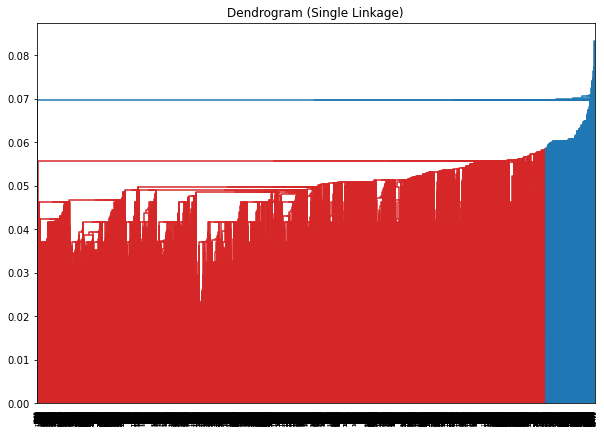

Metrics for Single Linkage with 3 clusters:
Contingency Matrix:
[[5451    1    1]
 [7157    0    0]]
Number of Clusters: 3
Samples per Cluster: [12608     1     1]
Silhouette Score: 0.11351762812625564
Davies-Bouldin Score: 0.7739795866509178


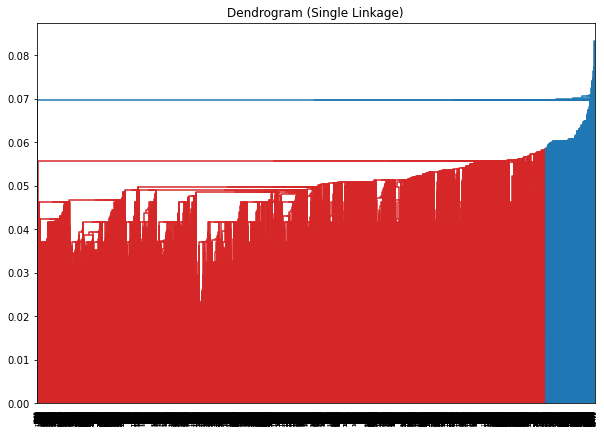

Metrics for Single Linkage with 4 clusters:
Contingency Matrix:
[[   2 5449    1    1]
 [   2 7155    0    0]]
Number of Clusters: 4
Samples per Cluster: [    4 12604     1     1]
Silhouette Score: 0.1016754062217174
Davies-Bouldin Score: 0.8878568872453731


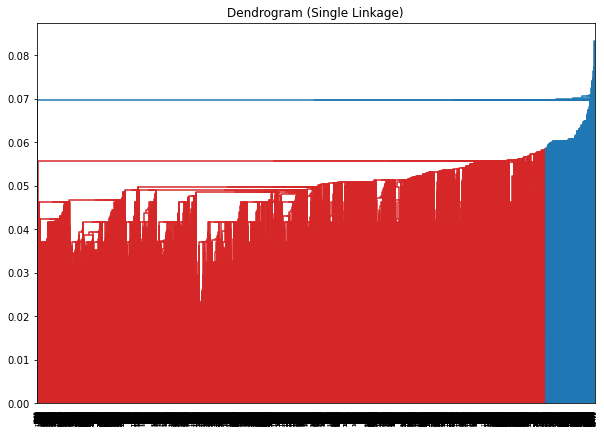

Metrics for Complete Linkage with 2 clusters:
Contingency Matrix:
[[2489 2964]
 [2347 4810]]
Number of Clusters: 2
Samples per Cluster: [4836 7774]
Silhouette Score: 0.02859152488109768
Davies-Bouldin Score: 6.2305317487160465


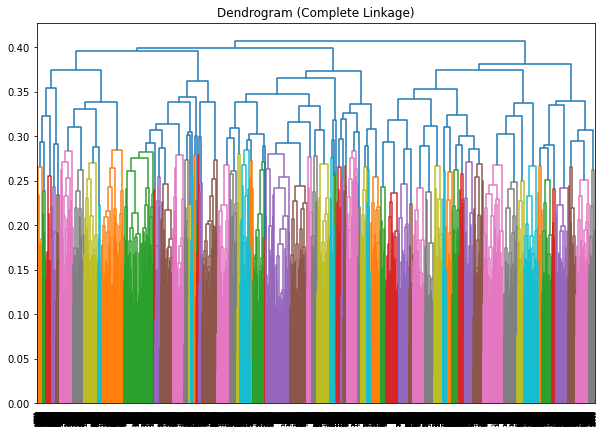

Metrics for Complete Linkage with 3 clusters:
Contingency Matrix:
[[2489 1353 1611]
 [2347 2334 2476]]
Number of Clusters: 3
Samples per Cluster: [4836 3687 4087]
Silhouette Score: 0.011874849754840232
Davies-Bouldin Score: 6.338597553221909


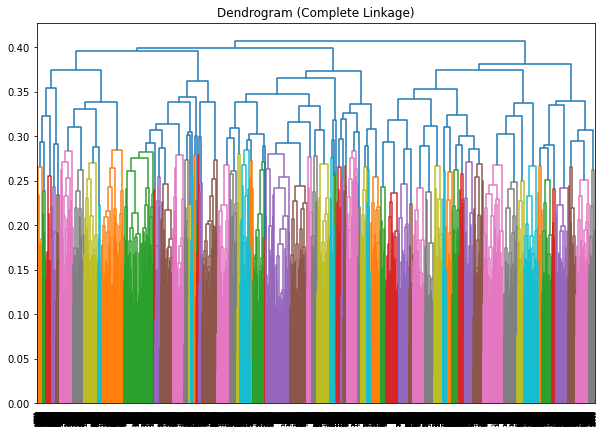

Metrics for Complete Linkage with 4 clusters:
Contingency Matrix:
[[2489 1353  759  852]
 [2347 2334 1349 1127]]
Number of Clusters: 4
Samples per Cluster: [4836 3687 2108 1979]
Silhouette Score: -0.0026552014174686485
Davies-Bouldin Score: 6.77726576449885


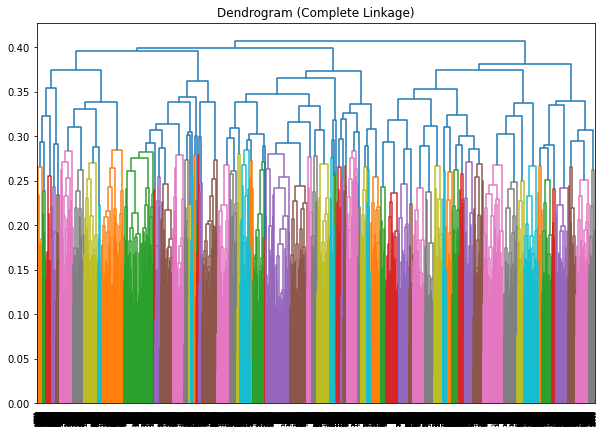

Metrics for Weighted Linkage with 2 clusters:
Contingency Matrix:
[[3106 2347]
 [3763 3394]]
Number of Clusters: 2
Samples per Cluster: [6869 5741]
Silhouette Score: 0.015110114980783134
Davies-Bouldin Score: 8.205504903616996


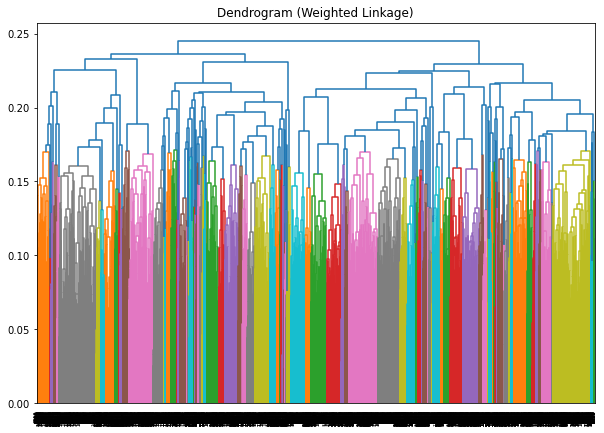

Metrics for Weighted Linkage with 3 clusters:
Contingency Matrix:
[[3106 1325 1022]
 [3763 1778 1616]]
Number of Clusters: 3
Samples per Cluster: [6869 3103 2638]
Silhouette Score: -0.0003118142447609479
Davies-Bouldin Score: 7.105630624243195


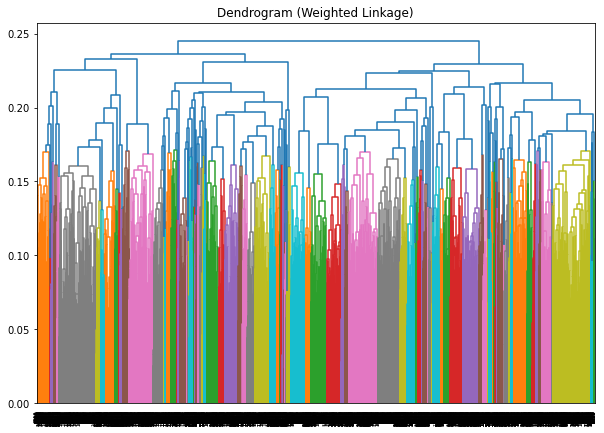

Metrics for Weighted Linkage with 4 clusters:
Contingency Matrix:
[[3106 1325  345  677]
 [3763 1778  338 1278]]
Number of Clusters: 4
Samples per Cluster: [6869 3103  683 1955]
Silhouette Score: -0.027806201483214308
Davies-Bouldin Score: 6.497344557601708


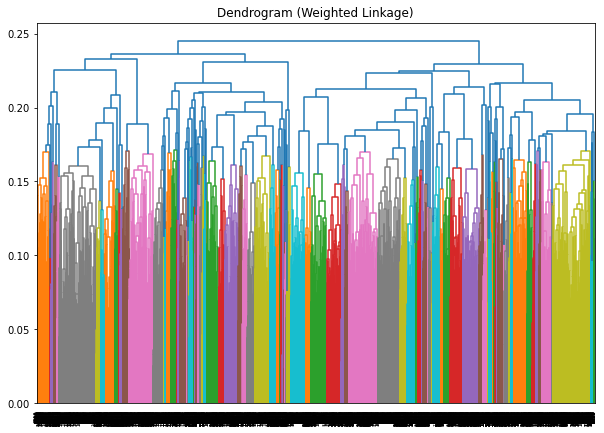

Metrics for Centroid Linkage with 2 clusters:
Contingency Matrix:
[[   2 5451]
 [   3 7154]]
Number of Clusters: 2
Samples per Cluster: [    5 12605]
Silhouette Score: 0.09657915443057309
Davies-Bouldin Score: 1.0843001539795691


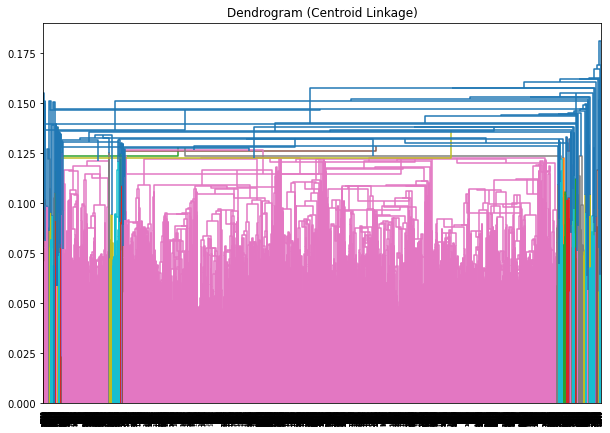

Metrics for Centroid Linkage with 3 clusters:
Contingency Matrix:
[[   2    0 5451]
 [   3   20 7134]]
Number of Clusters: 3
Samples per Cluster: [    5    20 12585]
Silhouette Score: -0.002771036103842546
Davies-Bouldin Score: 1.254778889159809


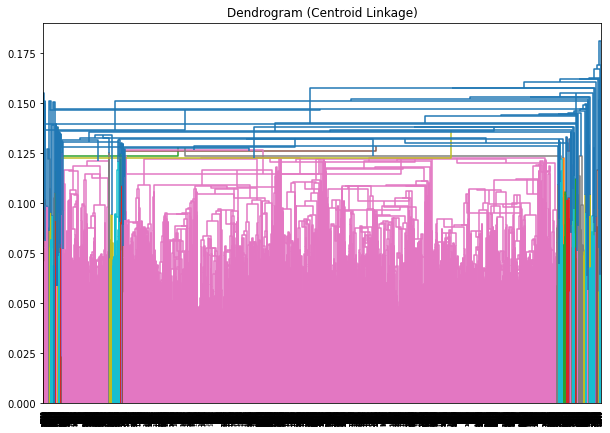

Metrics for Centroid Linkage with 4 clusters:
Contingency Matrix:
[[   2    0    0 5451]
 [   3   20    2 7132]]
Number of Clusters: 4
Samples per Cluster: [    5    20     2 12583]
Silhouette Score: -0.03350956366249361
Davies-Bouldin Score: 1.2167914063010101


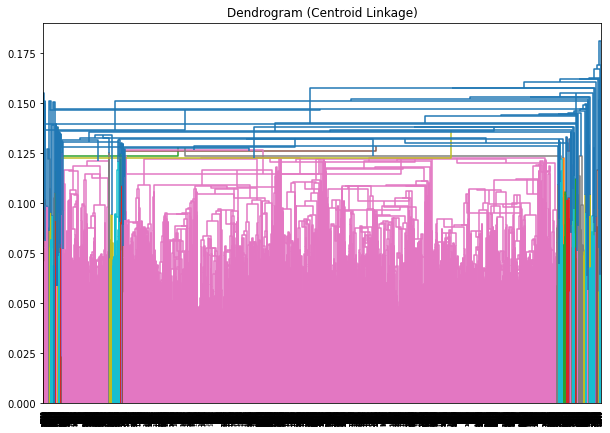

Metrics for Ward Linkage with 2 clusters:
Contingency Matrix:
[[1945 3508]
 [3278 3879]]
Number of Clusters: 2
Samples per Cluster: [5223 7387]
Silhouette Score: 0.02288891610036385
Davies-Bouldin Score: 6.132501281643912


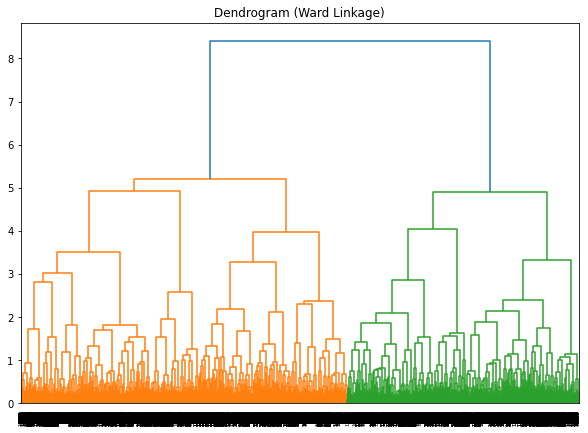

Metrics for Ward Linkage with 3 clusters:
Contingency Matrix:
[[1945 1561 1947]
 [3278 1808 2071]]
Number of Clusters: 3
Samples per Cluster: [5223 3369 4018]
Silhouette Score: 0.01478316527866095
Davies-Bouldin Score: 7.457196792108587


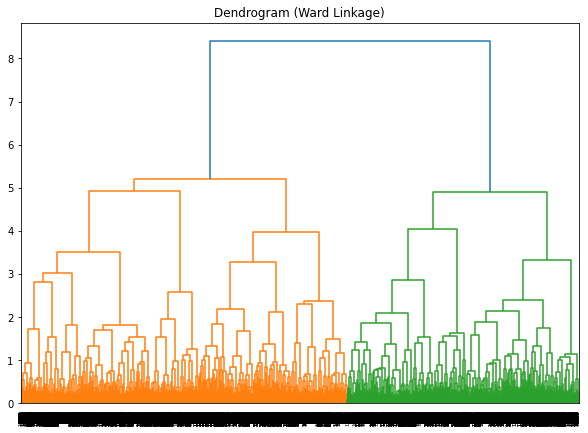

Metrics for Ward Linkage with 4 clusters:
Contingency Matrix:
[[1945 1561  621 1326]
 [3278 1808  471 1600]]
Number of Clusters: 4
Samples per Cluster: [5223 3369 1092 2926]
Silhouette Score: 0.010019359582466211
Davies-Bouldin Score: 6.683147405643668


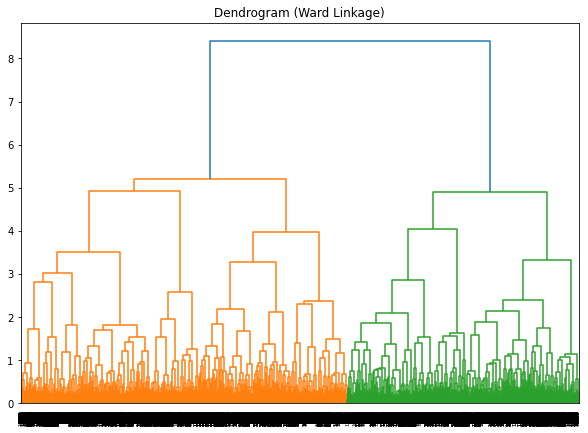

In [41]:
# Assuming X_mca is your MCA transformed DataFrame
gower_dist_matrix = gower.gower_matrix(X)

# Convert the Gower distance matrix to a condensed distance matrix
condensed_gower_dist_matrix = squareform(gower_dist_matrix)

linkage_methods = ['single', 'complete', 'weighted', 'centroid', 'ward']
n_clusters_range = range(2, 5)  # Example: considering 2 to 4 clusters

for method in linkage_methods:
    # Perform hierarchical clustering using the condensed Gower distance matrix
    linked = linkage(condensed_gower_dist_matrix, method=method)
    
    for n_clusters in n_clusters_range:
        # Obtain cluster labels
        y_pred = fcluster(linked, n_clusters, criterion='maxclust') 

        # Print contingency matrix and other metrics
        print(f"Metrics for {method.capitalize()} Linkage with {n_clusters} clusters:")
        print(f"Contingency Matrix:\n{metrics.cluster.contingency_matrix(y, y_pred)}")
        print(f"Number of Clusters: {np.unique(y_pred).size}")
        print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        # Uncomment and use the following lines if the respective functions are defined
        print(f"Silhouette Score: {silhouette(X, y_pred, n_clusters)}")
        print(f"Davies-Bouldin Score: {davis(X, y_pred, n_clusters)}")
        #print(f"Dunn Index: {dunn(X, y_pred)}\n")
        
        # Plot the dendrogram
        plt.figure(figsize=(10, 7))
        dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
        plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
        plt.show()

